In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook
%pwd

'/mnt/c/Users/mtr22/Code/mre-pinn/notebooks'

In [2]:
import sys, os, itertools
import numpy as np
import scipy
import torch
import matplotlib.pyplot as plt

sys.path.append('..')
%aimport mre_pinn

Using backend: pytorch



# 2D Poisson forward FEM

Following FEM wikipedia page we have for $u: \Omega \to \mathbb{R}$ and $f: \Omega \to \mathbb{R}$ where $\Omega = [-1, 1]^2$:

$$
\begin{align}
    \nabla^2 u &= f \\
    u(\mathbf{x}) &= 0 \qquad \mathbf{x} \in \Gamma
\end{align}
$$

We are given $f$ and the above PDE and boundary conditions, and we would like to solve for $u$.

Variational form:

$$
\begin{align}
    \int_\Omega \nabla^2 u v d\Omega &= \int_\Omega fv d\Omega \quad \forall v \in V
\end{align}
$$

Integration by parts:

$$
\begin{align}
    \int_\Omega \nabla^2 u v d\Omega &= \int_\Gamma \nabla u \cdot \mathbf{n} v d\Gamma - \int_\Omega \nabla u \cdot \nabla v d\Omega \\
    \int_\Omega \nabla^2 uv d\Omega &= -\int_\Omega \nabla u \cdot \nabla v d\Omega \\
    -\int_\Omega \nabla u \cdot \nabla v d\Omega &= \int_\Omega fv d\Omega \\
    \int_\Omega \nabla u \cdot \nabla v d\Omega &= -\int_\Omega fv d\Omega
\end{align}
$$

Domain discretization by 2D uniform mesh with $n^2$ nodes, for $i = [1, 2, ..., n^2-1, n^2]$:

$$
    \mathbf{x}_i = \ldots
$$

Basis functions:

$$
\begin{align}
    u = \sum_{i=1}^{n^2} u_i \phi_i \\
    f = \sum_{i=1}^{n^2} f_i \phi_i \\
    v = \sum_{i=1}^{n^2} v_i \phi_i
\end{align}
$$

Substitute and derive:

$$
\begin{align}
    \int_\Omega \nabla \left( \sum_{i=1}^{n^2} u_i \phi_i \right) \cdot \nabla \phi_j d\Omega &= -\int_\Omega \left( \sum_{i=1}^{n^2} f_i \phi_i \right) \phi_j d\Omega \\
    \int_\Omega  \sum_{i=1}^{n^2} u_i \nabla \phi_i \cdot \nabla \phi_j d\Omega &= -\int_\Omega \sum_{i=1}^{n^2} f_i \phi_i \phi_j d\Omega \\
    \sum_{i=1}^{n^2} u_i \left(\int_\Omega \nabla \phi_i \cdot \nabla \phi_j d\Omega \right) &= -\sum_{i=1}^{n^2} f_i \left( \int_\Omega  \phi_i \phi_j d\Omega \right) \\
\end{align}
$$

Assemble FEM matrices:

$$
\begin{align}
    \mathbf{K}_{ij} &= \int_\Omega \nabla \phi_i \cdot \nabla \phi_j d\Omega \\
    \mathbf{M}_{ij} &= \int_\Omega  \phi_i \phi_j d\Omega
\end{align}
$$

Linear system:

$$
    \mathbf{K} \mathbf{u} = -\mathbf{M} \mathbf{f}
$$

In [3]:
# define the basis function

def psi(x, nodes, radius=1):
    '''
    Evaluate piecewise linear basis functions.
    
    Args:
        x: (n_samples, ndim) array of positions to evaluate.
        nodes: (n_nodes, n_samples) array of node locations.
        radius: Scalar radius of basis functions.
    Returns:
        (n_nodes, n_samples) array of basis function values.
    '''
    nax = np.newaxis
    diff = (nodes[:,nax] - x[nax,:]) / radius
    dist = torch.norm(diff, np.inf, dim=2)
    return torch.clamp(1 - dist, min=0)


In [48]:
# define the reference mesh/element

ndim = 2
ref_mesh_shape = (3,) * ndim
n_ref_nodes = np.prod(ref_mesh_shape)

# uniform grid of reference nodes
ref_nodes = torch.cartesian_prod(
    *[torch.tensor([-1, 0, 1]) for i in range(ndim)]
)
if ndim == 1:
    ref_nodes = ref_nodes[:,nax]

ref_nodes, 2 / (torch.as_tensor(ref_mesh_shape) - 1)

(tensor([[-1, -1],
         [-1,  0],
         [-1,  1],
         [ 0, -1],
         [ 0,  0],
         [ 0,  1],
         [ 1, -1],
         [ 1,  0],
         [ 1,  1]]),
 tensor([1., 1.]))

In [49]:
# sample the domain for numerical integration of reference mesh

sample_shape = (201,) * ndim
n_samples = np.prod(sample_shape)

# uniform grid of samples
x = torch.cartesian_prod(
    *[torch.linspace(-1, 1, n) for n in sample_shape]
)
x.requires_grad = True

if ndim == 1:
    x = x[:,nax]

# sample resolution
dx = 2 / (torch.tensor(sample_shape) - 1)

n_samples, sample_shape, dx

(40401, (201, 201), tensor([0.0100, 0.0100]))

In [50]:
# evaluate basis functions on reference element
psi_x = psi(x, ref_nodes)

# evaluate gradient of each basis function
grad_psi_x = torch.zeros((n_ref_nodes, n_samples, ndim))
for i in range(n_ref_nodes):
    grad_psi_x[i] = torch.autograd.grad(psi_x[i], x, torch.ones_like(psi_x[i]), retain_graph=True)[0]

psi_x.shape, grad_psi_x.shape

(torch.Size([9, 40401]), torch.Size([9, 40401, 2]))

(3, 3, 201, 201, 3)
['node_x', 'node_y', 'x', 'y', 'component']


<IPython.core.display.Javascript object>


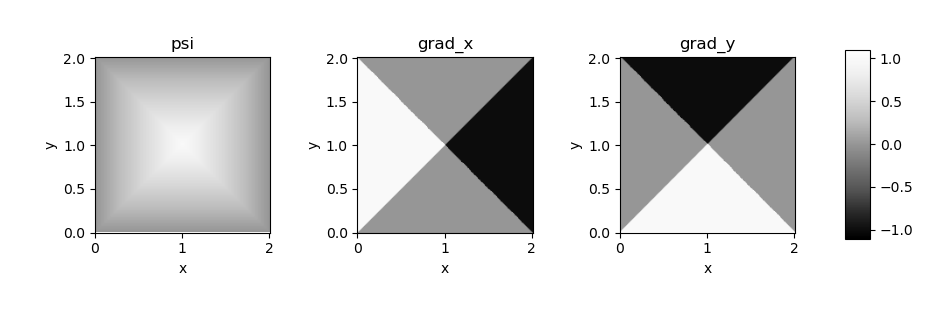

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [51]:
import xarray as xr

# visualize basis functions and gradients
a = np.concatenate([
    psi_x.detach().cpu().numpy().reshape(ref_mesh_shape + sample_shape + (1,)),
    grad_psi_x.detach().cpu().numpy().reshape(ref_mesh_shape + sample_shape + (ndim,))
], axis=-1)
print(a.shape)

dims = [f'node_{v}' for v in 'xyz'[:ndim]] + [v for v in 'xyz'[:ndim]] + ['component']
print(dims)
coords = {}
for i, v in enumerate('xyz'[:ndim]):
    coords[f'node_{v}'] = np.array([-1, 0, 1])
    coords[str(v)] = np.linspace(-1, 1, sample_shape[i])
    
coords['component'] = ['psi'] + [f'grad_{v}' for v in 'xyz'[:ndim]]

xr_psi_x = xr.DataArray(a, dims=dims, coords=coords)
mre_pinn.visual.XArrayViewer(xr_psi_x, col='component', vmin=-1.1, vmax=1.1, ax_height=2, cmap='Greys_r')

In [52]:
# reference element
#  to save on computation, we only compute the following between
#    the central node and every other node in the "reference mesh"
#  then we cache these values based on the diff from the central node
#  the values in the full mesh will then be obtained from the cache
#    where the cache key is the diff between the nodes

# get index of central node (should be located at origin)
m = n_ref_nodes // 2
assert np.allclose(0, ref_nodes[m])

# compute basis function products needed for variational form of PDE
print(psi_x.shape, grad_psi_x.shape)
nax = np.newaxis
M_products = (psi_x[m,nax] * psi_x)
K_products = (grad_psi_x[m,nax] * grad_psi_x).sum(dim=-1)
print(M_products.shape, K_products.shape)

# Riemann integrals of basis function products
dV = torch.prod(dx)
M_integrals = (M_products * dV).sum(dim=-1)
K_integrals = (K_products * dV).sum(dim=-1)
print(M_integrals.shape, K_integrals.shape)

# cache the integrals based on mesh topology
M_cache = {}
K_cache = {}
for i in range(n_ref_nodes):
    key = tuple(ref_nodes[i].detach().cpu().numpy())
    M_cache[key] = M_integrals[i].detach().cpu().numpy()
    K_cache[key] = K_integrals[i].detach().cpu().numpy()
    
M_cache, K_cache

torch.Size([9, 40401]) torch.Size([9, 40401, 2])
torch.Size([9, 40401]) torch.Size([9, 40401])
torch.Size([9]) torch.Size([9])


({(-1, -1): array(0.083325, dtype=float32),
  (-1, 0): array(0.20832497, dtype=float32),
  (-1, 1): array(0.08332501, dtype=float32),
  (0, -1): array(0.20832498, dtype=float32),
  (0, 0): array(0.6666999, dtype=float32),
  (0, 1): array(0.20832501, dtype=float32),
  (1, -1): array(0.083325, dtype=float32),
  (1, 0): array(0.208325, dtype=float32),
  (1, 1): array(0.083325, dtype=float32)},
 {(-1, -1): array(-0.005, dtype=float32),
  (-1, 0): array(0.01485, dtype=float32),
  (-1, 1): array(-0.00365, dtype=float32),
  (0, -1): array(0.01484999, dtype=float32),
  (0, 0): array(4.023749, dtype=float32),
  (0, 1): array(0.01464999, dtype=float32),
  (1, -1): array(-0.00365, dtype=float32),
  (1, 0): array(0.01465, dtype=float32),
  (1, 1): array(-0.0049, dtype=float32)})

That was all basically generic setup for any 2D FEM problem

Now we setup the specifics of the Poisson BVP we want to solve.

In [55]:
# define the problem mesh

# uniform grid of mesh nodes
ndim = 2
mesh_shape = (5,) * ndim
n_nodes = np.prod(mesh_shape)
print(n_nodes)

nodes = torch.cartesian_prod(*[torch.arange(n) for n in mesh_shape])
x_h = torch.cartesian_prod(*[torch.linspace(-1, 1, n) for n in mesh_shape])

# also sample domain for function evaluations (for visualization etc.)
sample_shape = (101,) * ndim
x = torch.cartesian_prod(*[torch.linspace(-1, 1, n) for n in sample_shape])

if ndim == 1:
    nodes = nodes[:,nax]
    x_h = x_h[:,nax]
    x = x[:,nax]

# mesh resolution
d_mesh = 2 / (torch.as_tensor(mesh_shape) - 1)

# remove boundary nodes
on_boundary = np.isclose(1, x_h.abs().max(dim=1)[0])

nodes = nodes[~on_boundary]
x_h = x_h[~on_boundary]
mesh_shape = tuple(d - 2 for d in mesh_shape)
n_nodes = np.prod(mesh_shape)
assert n_nodes == len(nodes)

x_h, n_nodes, d_mesh

25


(tensor([[-0.5000, -0.5000],
         [-0.5000,  0.0000],
         [-0.5000,  0.5000],
         [ 0.0000, -0.5000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.5000],
         [ 0.5000, -0.5000],
         [ 0.5000,  0.0000],
         [ 0.5000,  0.5000]]),
 9,
 tensor([0.5000, 0.5000]))

In [56]:
# assemble FEM matrices

print('Creating diff matrix')
diff = (nodes[:,nax] - nodes[nax,:]).detach().cpu().numpy()

print('Assembling FEM matrices')
dV = torch.prod(dx).detach().cpu().numpy()
print(dV)
M_rows, M_cols, M_values = [], [], []
K_rows, K_cols, K_values = [], [], []
for i in range(n_nodes):
    for j in range(n_nodes):
        key = tuple(diff[i,j])
        if key in M_cache:
            M_rows.append(i)
            M_cols.append(j)
            M_values.append(M_cache[key] * dV) # vector
        if key in K_cache:
            K_rows.append(i)
            K_cols.append(j)
            K_values.append(K_cache[key] / dV) # covector
            
M = scipy.sparse.coo_array((M_values, (M_rows, M_cols)), shape=(n_nodes, n_nodes))
K = scipy.sparse.coo_array((K_values, (K_rows, K_cols)), shape=(n_nodes, n_nodes))

print('Converting to sparse diagonal matrices')
M = scipy.sparse.dia_array(M)
K = scipy.sparse.dia_array(K)

Creating diff matrix
Assembling FEM matrices
1e-04
Converting to sparse diagonal matrices


In [46]:
def f(x):
    '''True forcing function.'''
    return -2 * torch.ones_like(x[:,0])

def u(x):
    '''True displacement function.'''
    return 1 - x**2

# sample forcing function on mesh and over full domain
f_h = f(x_h).cpu().detach().numpy()
f_x = f(x).cpu().detach().numpy()

# sample true displacement function on mesh and over full domain
#u_h = u(x_h).cpu().detach().numpy()
#u_x = u(x).cpu().detach().numpy()

# solve linear system of equations to obtain displacement coefficients on mesh
print(K.shape, M.shape, f_h.shape)
uhat_h = scipy.sparse.linalg.lsqr(K, -M @ f_h)[0][:,nax]
uhat_h[:] = 1

# sample displacement over full domain via basis functions
psi_x = psi(x, x_h, dx * 2).cpu().detach().numpy()
uhat_x = (uhat_h * psi_x).sum(axis=0)


(9, 9) (9, 9) (9,)


<IPython.core.display.Javascript object>


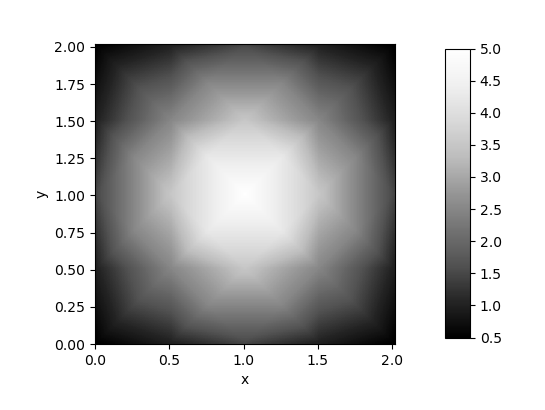

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [47]:
# visualize displacement function
a = uhat_x.reshape(*(sample_shape))

dims = [v for v in 'xyz'[:ndim]]
coords = {}
for i, v in enumerate('xyz'[:ndim]):
    coords[v] = np.linspace(-1, 1, sample_shape[i])

xr_uhat_x = xr.DataArray(a, dims=dims, coords=coords)
mre_pinn.visual.XArrayViewer(xr_uhat_x, ax_width=3, cmap='Greys_r')

# 1D Poisson inverse FEM

Similar problem setup as before:

$$
\begin{align}
    u''(x) &= f(x) \\
    u(-1) &= 0 \\
    u(1) &= 0
\end{align}
$$

But now we are given $u$ and we want to infer the forcing function $f$.

Variational form is the same:

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= \int_{-1}^1 f(x)v(x) dx \quad \forall v
\end{align}
$$

Integration by parts (note we cannot drop the boundary integral now, since $v$ is in the same space as $f$, which may not be zero on the boundary):

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= u'(x)v(x) \vert_{-1}^1 - \int_{-1}^1 u'(x)v'(x) dx \\
    u'(x)v(x) \vert_{-1}^1 - \int_{-1}^1 u'(x)v'(x) dx &= \int_{-1}^1 f(x)v(x) dx \\
    \int_{-1}^1 u'(x)v'(x) dx - u'(x)v(x) \vert_{-1}^1 &= -\int_{-1}^1 f(x)v(x) dx
\end{align}
$$

Domain discretization by 1D uniform mesh with $n$ nodes, for $i = [0, 1, ..., n - 1]$:

$$
    x_i = \frac{i}{n - 1}
$$

Basis functions:

$$
\begin{align}
    u(x) = \sum_{i=0}^{n - 1} u_i \phi_i(x) \\
    f(x) = \sum_{i=0}^{n - 1} f_i \phi_i(x) \\
    v(x) = \sum_{i=0}^{n - 1} v_i \phi_i(x)
\end{align}
$$

Substitute and derive:

$$
\begin{align}
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi_i(x) \right)' \phi_j'(x) dx - {\left( \sum_{i=0}^{n - 1} u_i \phi_i(x) \right)' \phi_j(x)} \vert_{-1}^1 &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi'_i(x) \right) \phi_j'(x) dx - \left( \sum_{i=0}^{n - 1} u_i \phi_i'(x) \right) \phi_j(x) \vert_{-1}^1 &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \sum_{i=0}^{n - 1} u_i \phi'_i(x) \phi_j'(x) dx - \sum_{i=0}^{n - 1} u_i \phi_i'(x) \phi_j(x) \vert_{-1}^1 &= -\int_{-1}^1 \sum_{i=0}^{n - 1} f_i \phi_i(x) \phi_j(x) dx \\
    \sum_{i=0}^{n - 1} u_i \left[ \left( \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \right) - \phi_i'(x) \phi_j(x) \vert_{-1}^1 \right] &= -\sum_{i=0}^{n - 1} f_i \left( \int_{-1}^1  \phi_i(x) \phi_j(x) dx \right) \\
    \sum_{i=0}^{n - 1} f_i \left( \int_{-1}^1  \phi_i(x) \phi_j(x) dx \right) &= \sum_{i=0}^{n - 1} u_i \left[ \phi_i'(x) \phi_j(x) \vert_{-1}^1 - \left( \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \right) \right]
\end{align}
$$

Assemble FEM matrices:

$$
\begin{align}
    \mathbf{M}_{ij} &= \int_{-1}^1 \phi_i(x) \phi_j(x) dx \\
    \mathbf{K}_{ij} &= \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \\
    \mathbf{T}_{ij} &= \phi_i'(x) \phi_j(x) \vert_{-1}^1
\end{align}
$$

Linear system:

$$
    \mathbf{M} \mathbf{f} = \left( \mathbf{T} - \mathbf{K} \right) \mathbf{u}
$$

In [ ]:
# define the mesh
ndim = 1
n_nodes = 21
nax = np.newaxis
nodes = torch.linspace(-1, 1, n_nodes)[:,nax]

# mesh resolution
d_node = nodes[1] - nodes[0]

# remove boundary nodes
nodes = nodes[1:-1]
n_nodes -= 2

# domain samples
n_samples = 40001
x = torch.linspace(-1, 1, n_samples)[:,nax]
x.requires_grad = True

# sample resolution
dx = x[1] - x[0]

psi_x = psi(x, nodes, d_node)

# evaluate gradient of each basis function
grad_psi_x = torch.zeros((n_nodes**ndim, n_samples**ndim, ndim))
for i in range(n_nodes**ndim):
    grad_psi_x[i] = torch.autograd.grad(psi_x[i], x, torch.ones_like(psi_x[i]), retain_graph=True)[0]
    
fig, axes = plt.subplots(2, 1, figsize=(8,4))
axes[0].plot(x.detach().cpu().numpy(), psi_x.detach().cpu().numpy().T, label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), grad_psi_x.detach().cpu().numpy()[...,0].T, label=range(n_nodes))
axes[0].set_ylabel(r'$\psi(x)$')
axes[1].set_ylabel(r'$\nabla\psi(x)$')
axes[1].set_xlabel(r'$x$')

We will now assemble the FEM matrices, but we need to include a traction matrix:
    
$$
\begin{align}
    \mathbf{T}_{ij} &= \phi_i'(x) \phi_j(x) \vert_{-1}^1 \\
    \mathbf{T}_{ij} &= \phi_i'(1) \phi_j(1) - \phi_i'(-1) \phi_j(-1) \\
    \mathbf{T}_{ij} &= \int_\Gamma n\phi_i'(x) \phi_j(x) dx \\
\end{align}
$$

Where $n$ is the boundary normal, i.e. $n = 1$ for the right boundary and $n = -1$ for the left boundary.

In [ ]:
# get the boundary normals
normal = torch.zeros(n_samples, ndim)
left_boundary = (x[:,0] == -1)
right_boundary = (x[:,0] == 1)
normal[left_boundary,0] = -1
normal[right_boundary,0] = 1
normal.shape

In [ ]:
# compute basis function products and integrals

M_products = (psi_x[:,nax,:] * psi_x[nax,:,:])
T_products = (psi_x[:,nax,:,nax] * grad_psi_x[nax,:] * normal[nax,nax]).sum(dim=-1) # dot product
K_products = (grad_psi_x[:,nax,...] * grad_psi_x[nax,:,...]).sum(dim=-1) # dot product

# simple Riemannian integration
M = (M_products * dx).sum(dim=-1)
T = (T_products).sum(dim=-1)
K = (K_products * dx).sum(dim=-1)

print(M.shape, T.shape, K.shape)

In [ ]:
def f(x):
    '''True forcing function.'''
    return -2 * torch.ones_like(x)

def u(x):
    '''True displacement function.'''
    return 1 - x**2

# sample forcing function on mesh and over full domain
f_h = f(nodes)
f_x = f(x)

# sample true displacement function on mesh and over full domain
u_h = u(nodes)
u_x = u(x)

# solve linear system of equations
fhat_h = torch.linalg.solve(M, -K @ u_h)

# linear combination of basis functions
fhat_psi_x = (fhat_h * psi_x)
fhat_x = fhat_psi_x.sum(dim=0, keepdim=True).T

fig, axes = plt.subplots(3, 1, figsize=(8,6))
axes[0].plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), f_x.detach().cpu().numpy(), label=range(n_nodes))
axes[2].plot(x.detach().cpu().numpy(), fhat_x.detach().cpu().numpy(), label=range(n_nodes))
#axes[2].plot(x.detach().cpu().numpy(), fhat_psi_x.detach().cpu().numpy().T, label=range(n_nodes), zorder=0)
axes[0].set_ylabel(r'$u(x)$')
axes[1].set_ylabel(r'$f(x)$')
axes[2].set_ylabel(r'$\hat{f}(x)$')
axes[-1].set_xlabel(r'$x$')